In [1]:
import pandas as pd
import numpy as np
import torch

import sys
sys.path.insert(1, '../')
import data_handler

/storagenfs/m.melerocavallo/HLTKeyPointAnalysis/venv2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
device = torch.device(2)

# Data Management

In [14]:
df_train, df_val, df_test = data_handler.load_full_dataset('../dataset/', get_train=True, get_dev=True, get_test=True)

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24093 entries, 0 to 3457
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   24093 non-null  object
 1   key_point  24093 non-null  object
 2   topic      24093 non-null  object
 3   stance     24093 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 941.1+ KB


In [16]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3426 entries, 0 to 3425
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   argument   3426 non-null   object
 1   key_point  3426 non-null   object
 2   topic      3426 non-null   object
 3   stance     3426 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 107.2+ KB


In [17]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18398 entries, 0 to 18397
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   argument  18398 non-null  object
 1   topic     18398 non-null  object
 2   stance    18398 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 431.3+ KB


In [18]:
print(f"Number of unique topics present in Training set: {len(df_train['topic'].unique())}")
print(f"Number of unique topics present in Validation set: {len(df_val['topic'].unique())}")
print(f"Number of unique topics present in Test set: {len(df_test['topic'].unique())}")

Number of unique topics present in Training set: 28
Number of unique topics present in Validation set: 3
Number of unique topics present in Test set: 43


In [19]:
#Check if there are some shared topics
print(f"Overlap of topics between Training and Validation: {len(np.intersect1d(df_train['topic'].unique(), df_val['topic'].unique()))}")
print(f"Overlap of topics between Training and Test: {len(np.intersect1d(df_train['topic'].unique(), df_test['topic'].unique()))}")
print(f"Overlap of topics between Test and Validation: {len(np.intersect1d(df_val['topic'].unique(), df_test['topic'].unique()))}")

Overlap of topics between Training and Validation: 0
Overlap of topics between Training and Test: 0
Overlap of topics between Test and Validation: 0


In [20]:
# Concatenate topics and keypoints, as stated in the paper
df_train = data_handler.concatenate_topics(df_train, input_col='argument', output_col='argument')
df_val = data_handler.concatenate_topics(df_val, input_col='argument', output_col='argument')
df_test = data_handler.concatenate_topics(df_test, input_col='argument', output_col='argument')

In [21]:
n_words = pd.DataFrame()
n_words['words_per_arg_train'] = df_train['argument'].str.split().apply(len)
n_words['words_per_arg_val'] = df_val['argument'].str.split().apply(len)
n_words['words_per_arg_test'] = df_test['argument'].str.split().apply(len)

<AxesSubplot: >

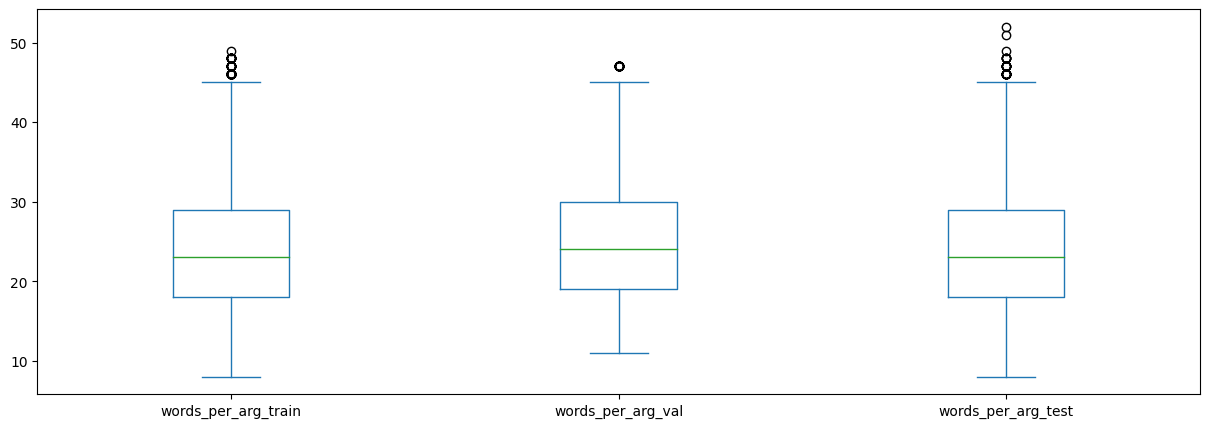

In [22]:
n_words.plot.box(figsize=(15, 5))

In [23]:
print(f"Max number of words for Training args: {n_words['words_per_arg_train'].max()}")
print(f"Max number of words for Validation args: {n_words['words_per_arg_val'].max()}")
print(f"Max number of words for Test args: {n_words['words_per_arg_test'].max()}\n")

Max number of words for Training args: 49
Max number of words for Validation args: 47.0
Max number of words for Test args: 52.0



In [ ]:
def convert_examples_to_features(example_batch):
    input_encodings = tokenizer(example_batch["dialogue"], max_length=1024,
    truncation=True)

    with tokenizer.as_target_tokenizer():
        target_encodings = tokenizer(example_batch["summary"], max_length=128,
            truncation=True)
    return {"input_ids": input_encodings["input_ids"],
        "attention_mask": input_encodings["attention_mask"],
        "labels": target_encodings["input_ids"]}
    

dataset_samsum_pt = dataset_samsum.map(convert_examples_to_features,
batched=True)
columns = ["input_ids", "labels", "attention_mask"]
dataset_samsum_pt.set_format(type="torch", columns=columns)

In [ ]:
d_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["dialogue"]]
s_len = [len(tokenizer.encode(s)) for s in dataset_samsum["train"]["summary"]]
fig, axes = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
axes[0].hist(d_len, bins=20, color="C0", edgecolor="C0")
axes[0].set_title("Dialogue Token Length")
axes[0].set_xlabel("Length")

axes[0].set_ylabel("Count")
axes[1].hist(s_len, bins=20, color="C0", edgecolor="C0")
axes[1].set_title("Summary Token Length")
axes[1].set_xlabel("Length")
plt.tight_layout()
plt.show()